In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set(style='ticks', palette='Set2')
%matplotlib inline

### Dataset 1: Air Pollution Along the Wasatch Front

This first dataset contains pollution and weather variables for the Wasatch front (Ogden to Spanish Fork). We first clean the dataset, getting rid of unwanted variables and observations. Next we create our own average pollution variable for the Wasatch front. Then we describe the data, seeing how pollution is correlated with temperature and precipitation. Finally we visualize the data, looking at the distribution of pollution levels and how they have changed along the Wasatch front from 2000-2016.

In [2]:
# Here we read in a SAS dataset and create a Pandas datafile. The SAS dataset is a dataset of pollution and weather variables.
# The weather variables were measured at SLC International Airport. The pollution variables are measures of fine particulate 
# matter (pm2.5) in ug/m^3. These were measured at community air monitors along the Wasatch front. The pollution data were
# downloaded from the EPA and merged with the weather data previously by myself.
pollution_data = pd.read_sas('C:\\Users\\jacob\\Documents\\Datasets\\utah_pollution_weather_opt1.sas7bdat', format='sas7bdat')

In [3]:
# Here we create a "Date" collumn. We use the to_timedelta and Timestamp functions to convert the SAS "date_final" variable
# to the python date format we want to use. We add 1Jan1960 since this is the date that SAS dates count from.
# Then we set the index to the date.
pollution_data['Date']=pd.to_timedelta(pollution_data['date_final'], unit='D') + pd.Timestamp('1960-1-1')
pollution_data = pollution_data.set_index('Date')

In [4]:
# We drop date and date_final (use the index), the Logan pollution data to restrict ourselves to the Wasatch front 
# (from Ogden to Spanish Fork), weather variables we aren't interested in, and pm10 data (another measure of air pollution).
cols_delete = ['date_final', 'pm25_logan', 'dewpoint', 'sealevel_pressure', 'station_pressure', 'visibility', 'windspeed',
              'min_temp', 'max_temp', 'max_windspeed', 'max_windgust', 'snow_depth', 'pm10_bountiful', 'pm10_hawthorne',
              'pm10_lindon', 'pm10_logan', 'pm10_northprovo', 'pm10_ogden', 'pm10_rosepark', 'pm10_spanishfork', 'pm10_magna']
pollution_data = pollution_data.drop(labels=cols_delete, axis=1)

In [5]:
# Measuring pm2.5 did not become common practice until 1999. Here we restrict ourselves to the data from 1Jan2000 to 31Dec2016
pollution_data = pollution_data.drop(pollution_data.index[0:5478])

In [6]:
# In my experience, missing pollution measures are for the most part random. We will use an average of all the
# monitors to overcome this. We will also later address missing values for precipitation.
# Here we look at which collumns are missing data.
pollution_data.columns[pollution_data.isnull().any()]

Index(['pm25_bountiful', 'pm25_hawthorne', 'pm25_lindon', 'pm25_northprovo',
       'pm25_ogden', 'pm25_rosepark', 'pm25_spanishfork', 'pm25_magna',
       'precipitation'],
      dtype='object')

In [7]:
# We create the mean pollution level for the Wasatch front. Each monitor is weighted equally. Note that "cols" was created above.
# We create a list called cols to do this. We remake this list after making our new columns.
cols = pollution_data.columns.tolist()
pm25_cols = [e for e in cols if e not in ('mean_temp', 'precipitation')]
pollution_data['Wasatch Mean pm2.5'] = pollution_data[pm25_cols].sum(axis=1)/len(pm25_cols)
cols = pollution_data.columns.tolist()

In [8]:
# We look at our variables. Next we will change their order.
pollution_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6210 entries, 2000-01-01 to 2016-12-31
Data columns (total 11 columns):
pm25_bountiful        2318 non-null float64
pm25_hawthorne        5964 non-null float64
pm25_lindon           5863 non-null float64
pm25_northprovo       4043 non-null float64
pm25_ogden            3901 non-null float64
pm25_rosepark         3092 non-null float64
pm25_spanishfork      1933 non-null float64
pm25_magna            1560 non-null float64
mean_temp             6210 non-null float64
precipitation         6206 non-null float64
Wasatch Mean pm2.5    6210 non-null float64
dtypes: float64(11)
memory usage: 582.2 KB


In [9]:
# We rearrange the collumns so that Wasatch mean, mean temperature, and precipitation will be at the front.
cols = cols[-1:] + cols[-3:-1] + cols[:-1]
pollution_data = pollution_data[cols]

In [10]:
# We look at our variables again. They're in the right order and have the right types.
pollution_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6210 entries, 2000-01-01 to 2016-12-31
Data columns (total 13 columns):
Wasatch Mean pm2.5    6210 non-null float64
mean_temp             6210 non-null float64
precipitation         6206 non-null float64
pm25_bountiful        2318 non-null float64
pm25_hawthorne        5964 non-null float64
pm25_lindon           5863 non-null float64
pm25_northprovo       4043 non-null float64
pm25_ogden            3901 non-null float64
pm25_rosepark         3092 non-null float64
pm25_spanishfork      1933 non-null float64
pm25_magna            1560 non-null float64
mean_temp             6210 non-null float64
precipitation         6206 non-null float64
dtypes: float64(13)
memory usage: 679.2 KB


In [11]:
# There is significant variance in air pollution, as can be seen. This is not surprising, and max values are considered to be
# accurate. Although negative air pollution is impossible, the negative minimums reflect minor errors in instrumentation.
# As we expected, the Wasatch mean is the mean of the means.
pollution_data.describe()

,Wasatch Mean pm2.5,mean_temp,precipitation,pm25_bountiful,pm25_hawthorne,pm25_lindon,pm25_northprovo,pm25_ogden,pm25_rosepark,pm25_spanishfork,pm25_magna,mean_temp,precipitation
count,6210.000000,6210.000000,6206.000000,2318.000000,5964.000000,5863.000000,4043.000000,3901.000000,3092.000000,1933.000000,1560.000000,6210.000000,6206.000000
mean,5.552738,53.815572,0.041097,9.111087,10.276995,9.765444,9.059436,10.005870,10.004528,8.505122,8.435321,53.815572,0.041097
std,6.100766,19.270258,0.121806,9.022721,10.828650,9.938652,9.098448,9.146976,9.274220,9.247604,8.673072,19.270258,0.121806
min,0.000000,5.100000,0.000000,0.000000,0.000000,-0.100000,0.000000,-0.400000,0.000000,0.000000,0.000000,5.100000,0.000000
25%,2.175000,37.900000,0.000000,4.300000,4.700000,4.700000,4.700000,5.100000,4.700000,4.200000,3.800000,37.900000,0.000000
50%,3.787500,52.800000,0.000000,6.300000,6.700000,6.800000,6.500000,7.300000,7.100000,6.000000,5.900000,52.800000,0.000000
75%,6.409375,71.000000,0.010000,10.000000,10.700000,10.500000,9.700000,10.700000,11.200000,8.700000,8.900000,71.000000,0.010000
max,68.087500,92.200000,1.440000,81.300000,94.200000,123.300000,124.500000,108.300000,78.200000,125.900000,69.000000,92.200000,1.440000


In [12]:
# Missing precipitation data may give us problems. To overcome this, we replace missing values with 0
# This is not a bad assumption for Utah (see summary stats)
pollution_data['precipitation'] = pollution_data['precipitation'].fillna(value=0)

In [13]:
# We make sure we don't have missing data for mean pollution, mean temperature, or precipitation.
pollution_data.columns[pollution_data.isnull().any()]

Index(['pm25_bountiful', 'pm25_hawthorne', 'pm25_lindon', 'pm25_northprovo',
       'pm25_ogden', 'pm25_rosepark', 'pm25_spanishfork', 'pm25_magna'],
      dtype='object')

In [14]:
# We look at summary statistics again to make sure we didn't change average precipitation too drastically.
# It lowered, but only slightly. That's comforting.
pollution_data.describe()

,Wasatch Mean pm2.5,mean_temp,precipitation,pm25_bountiful,pm25_hawthorne,pm25_lindon,pm25_northprovo,pm25_ogden,pm25_rosepark,pm25_spanishfork,pm25_magna,mean_temp,precipitation
count,6210.000000,6210.000000,6210.000000,2318.000000,5964.000000,5863.000000,4043.000000,3901.000000,3092.000000,1933.000000,1560.000000,6210.000000,6210.000000
mean,5.552738,53.815572,0.041071,9.111087,10.276995,9.765444,9.059436,10.005870,10.004528,8.505122,8.435321,53.815572,0.041071
std,6.100766,19.270258,0.121772,9.022721,10.828650,9.938652,9.098448,9.146976,9.274220,9.247604,8.673072,19.270258,0.121772
min,0.000000,5.100000,0.000000,0.000000,0.000000,-0.100000,0.000000,-0.400000,0.000000,0.000000,0.000000,5.100000,0.000000
25%,2.175000,37.900000,0.000000,4.300000,4.700000,4.700000,4.700000,5.100000,4.700000,4.200000,3.800000,37.900000,0.000000
50%,3.787500,52.800000,0.000000,6.300000,6.700000,6.800000,6.500000,7.300000,7.100000,6.000000,5.900000,52.800000,0.000000
75%,6.409375,71.000000,0.010000,10.000000,10.700000,10.500000,9.700000,10.700000,11.200000,8.700000,8.900000,71.000000,0.010000
max,68.087500,92.200000,1.440000,81.300000,94.200000,123.300000,124.500000,108.300000,78.200000,125.900000,69.000000,92.200000,1.440000


In [15]:
# As we would expect, air pollution along the Wasatch front is very highly correlated in different cities. Also, closer cities
# are more highly correlated. Surprisingly, mean_temp is negatively correlated with air pollution. It's not surprising that 
# precipitation is negatively correlated with pollution since weather fronts generally push dirty air out of the values.
pollution_data.corr()

,Wasatch Mean pm2.5,mean_temp,precipitation,pm25_bountiful,pm25_hawthorne,pm25_lindon,pm25_northprovo,pm25_ogden,pm25_rosepark,pm25_spanishfork,pm25_magna,mean_temp,precipitation
Wasatch Mean pm2.5,1.000000,-0.292239,-0.134291,0.909122,0.787002,0.798201,0.892776,0.872836,0.881083,0.899567,0.927938,-0.292239,-0.134291
mean_temp,-0.292239,1.000000,-0.148100,-0.300567,-0.400189,-0.345827,-0.303971,-0.294893,-0.277059,-0.299811,-0.302965,1.000000,-0.148100
precipitation,-0.134291,-0.148100,1.000000,-0.156001,-0.139161,-0.144097,-0.138725,-0.157516,-0.166791,-0.127830,-0.162574,-0.148100,1.000000
pm25_bountiful,0.909122,-0.300567,-0.156001,1.000000,0.923848,0.804787,0.777824,0.862737,0.871214,0.752965,0.919447,-0.300567,-0.156001
pm25_hawthorne,0.787002,-0.400189,-0.139161,0.923848,1.000000,0.862539,0.843533,0.879719,0.932252,0.808365,0.937457,-0.400189,-0.139161
pm25_lindon,0.798201,-0.345827,-0.144097,0.804787,0.862539,1.000000,0.968206,0.794902,0.796579,0.941236,0.813440,-0.345827,-0.144097
pm25_northprovo,0.892776,-0.303971,-0.138725,0.777824,0.843533,0.968206,1.000000,0.779626,0.784587,0.954694,0.796695,-0.303971,-0.138725
pm25_ogden,0.872836,-0.294893,-0.157516,0.862737,0.879719,0.794902,0.779626,1.000000,0.885570,0.736090,0.879691,-0.294893,-0.157516
pm25_rosepark,0.881083,-0.277059,-0.166791,0.871214,0.932252,0.796579,0.784587,0.885570,1.000000,0.749956,0.935762,-0.277059,-0.166791
pm25_spanishfork,0.899567,-0.299811,-0.127830,0.752965,0.808365,0.941236,0.954694,0.736090,0.749956,1.000000,0.770826,-0.299811,-0.127830


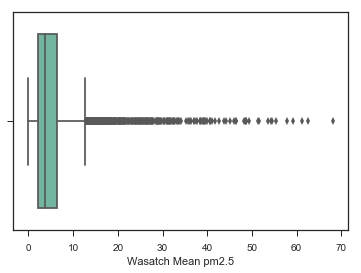

In [16]:
# Visualize the distribution with a box plot. Here we see that pm2.5 is no normally distributed.
sns.boxplot(pollution_data['Wasatch Mean pm2.5'])

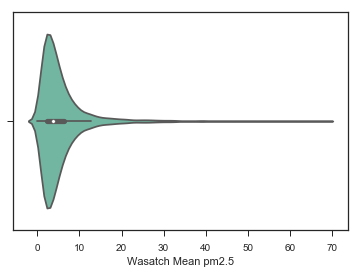

In [17]:
# Visualize with violin plot. It tells a similar story. PM2.5 levels are often near but not equal to 0. Very positively skewed.
sns.violinplot(pollution_data['Wasatch Mean pm2.5'])

C:\Users\jacob\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


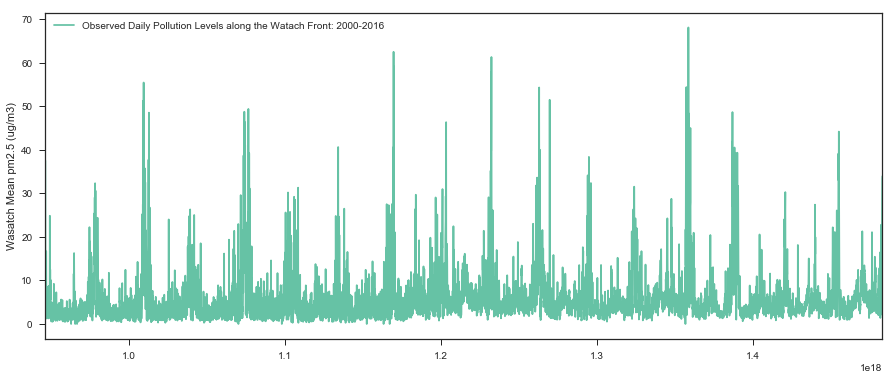

In [18]:
# Here we make our first crude time series plot. We not that the jumps in air pollution seem periodic, perhaps seasonal. This 
# is likely because temperature inversions in the valleys tend to trap air pollution when they occur during the winter months.
f, ax = plt.subplots(figsize=(15, 6))
sns.tsplot(pollution_data['Wasatch Mean pm2.5'], time=pollution_data.index.to_pydatetime(), value='Wasatch Mean pm2.5 (ug/m3)',
          ax=ax, condition='Observed Daily Pollution Levels along the Watach Front: 2000-2016', legend=True)

In [19]:
# We want to visualize our data by looking at monthly averages and how these change from year to year. We make another dataset
# and use the resample function to take monthly averages. We start using "pollution" to make the interpretation easier.
monthly_summary = pd.DataFrame()
monthly_summary['Pollution'] = pollution_data['Wasatch Mean pm2.5'].resample('M').mean()
monthly_summary.head()

,Pollution
Date,
2000-01-31,5.552016
2000-02-29,3.793966
2000-03-31,2.599597
2000-04-30,2.292500
2000-05-31,2.030645


In [20]:
# Now we create variables that mark the month and year of the observed average pollution
monthly_summary['Month'] = pd.DatetimeIndex(monthly_summary.index).month
monthly_summary['Year'] = pd.DatetimeIndex(monthly_summary.index).year

In [21]:
# This function pivots the table into the format we need.
month_sum_piv = monthly_summary.pivot('Month', 'Year', 'Pollution')

In [22]:
# We confirm that it looks how we want it to.
month_sum_piv.head()

Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Month,,,,,,,,,,,,,,,,,
1,5.552016,10.485081,9.592339,6.812500,15.928629,8.071371,4.908871,14.274597,9.829839,19.114516,17.577419,15.391532,8.487500,26.546774,17.654435,13.587500,9.901613
2,3.793966,4.195982,11.597321,4.271875,12.251724,6.047321,5.243750,3.949554,12.840517,7.518304,8.888839,4.181696,5.007328,13.521429,3.587500,3.177232,14.084052
3,2.599597,2.629435,2.682661,2.217339,4.844355,2.479435,2.377016,3.355242,4.441935,5.495968,6.604032,3.384274,3.606855,5.256452,2.551210,3.401210,3.265726
4,2.292500,2.664167,2.277500,2.442917,3.117500,2.753750,2.413333,3.107083,6.970417,3.993750,4.210833,3.047917,2.780417,3.268333,3.012917,4.538750,2.662500
5,2.030645,2.085887,2.081855,2.073387,3.408468,2.522984,2.864919,3.775403,5.523387,4.533065,3.238306,2.347581,5.194355,3.240323,3.653629,3.015323,3.396371


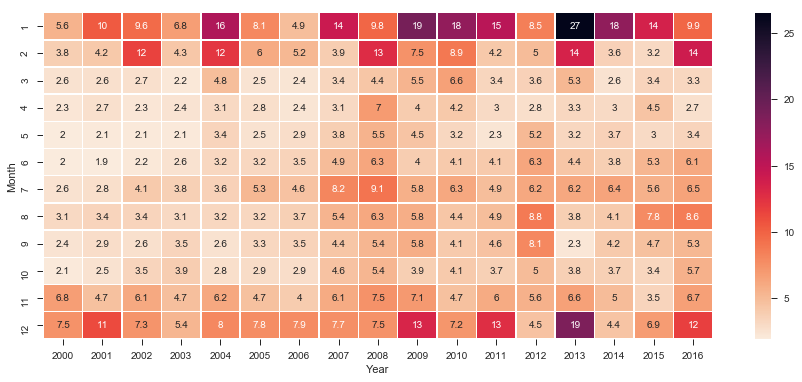

In [23]:
# Finally we're ready for the glorious heat map. Note that the boxes tend to get darker from year to year. I had thought 
# pollutio had been decreasing over the last several years. This figure tells a different story for the Wasatch front. Pollution
# levels are still generally increasing, especially throughout the summer months. 
f, ax = plt.subplots(figsize=(15, 6))
cmap = sns.cm.rocket_r #Inverts the color scheme so darker represents the higher value.
sns.heatmap(month_sum_piv, annot=True, ax=ax, linewidths=.5, cmap=cmap)

### Dataset 2: Yearrly Meteor Counts

These data are from NASA's Open Data Portal. They consist of the names, locations, and years of all known meteor landings. We first import the data. Then we clean it by extracting the year from each recorded meteor. Then we visualize the data by looking at the number of recorded meteor landings from 1970 to 1999 plotted by year. We also look at the distribution of meteor landings.

In [24]:
# Here we import the dataset and look at the types of the variables.
meteor_df = pd.read_csv("C:\\Users\\jacob\\Documents\\Datasets\\Meteorite-Landings.tsv", sep='\t', header=0,
                            index_col='Name')
meteor_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45716 entries, Aachen to Zulu Queen
Data columns (total 7 columns):
ID                45716 non-null int64
NameType          45716 non-null object
Classification    45716 non-null object
Mass              45716 non-null object
Fall              45716 non-null object
Year              45716 non-null object
Coordinates       45716 non-null object
dtypes: int64(1), object(6)
memory usage: 2.8+ MB


In [25]:
# We take a look at the first few rows of our dataset
meteor_df.head()

,ID,NameType,Classification,Mass,Fall,Year,Coordinates
Name,,,,,,,
Aachen,1,Valid,L5,"Quantity[21, ""Grams""]",Fell,"DateObject[{1880}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{50.775, 6.08333}]"
Aarhus,2,Valid,H6,"Quantity[720, ""Grams""]",Fell,"DateObject[{1951}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{56.18333, 10.23333}]"
Abee,6,Valid,EH4,"Quantity[107000, ""Grams""]",Fell,"DateObject[{1952}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{54.21667, -113.}]"
Acapulco,10,Valid,Acapulcoite,"Quantity[1914, ""Grams""]",Fell,"DateObject[{1976}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{16.88333, -99.9}]"
Achiras,370,Valid,L6,"Quantity[780, ""Grams""]",Fell,"DateObject[{1902}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{-33.16667, -64.95}]"


In [26]:
# We drop the observations that don't have information about what year they were found. Note that we have about 300 fewer.
# We also restrict ourselves to the years 1900-1999.
meteor_df = meteor_df[meteor_df['Year'].str[:14] == 'DateObject[{19']
meteor_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24976 entries, Aarhus to Zulu Queen
Data columns (total 7 columns):
ID                24976 non-null int64
NameType          24976 non-null object
Classification    24976 non-null object
Mass              24976 non-null object
Fall              24976 non-null object
Year              24976 non-null object
Coordinates       24976 non-null object
dtypes: int64(1), object(6)
memory usage: 1.5+ MB


In [27]:
# Now we are ready to extract the year as an integer from  the messy string we have it in.
meteor_df['Year_int'] = meteor_df['Year'].str[12:16].astype(int)
meteor_df.head()

,ID,NameType,Classification,Mass,Fall,Year,Coordinates,Year_int
Name,,,,,,,,
Aarhus,2,Valid,H6,"Quantity[720, ""Grams""]",Fell,"DateObject[{1951}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{56.18333, 10.23333}]",1951
Abee,6,Valid,EH4,"Quantity[107000, ""Grams""]",Fell,"DateObject[{1952}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{54.21667, -113.}]",1952
Acapulco,10,Valid,Acapulcoite,"Quantity[1914, ""Grams""]",Fell,"DateObject[{1976}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{16.88333, -99.9}]",1976
Achiras,370,Valid,L6,"Quantity[780, ""Grams""]",Fell,"DateObject[{1902}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{-33.16667, -64.95}]",1902
Adhi Kot,379,Valid,EH4,"Quantity[4239, ""Grams""]",Fell,"DateObject[{1919}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{32.1, 71.8}]",1919


In [28]:
# Ideally I could have done this with a loop, but I'm still trying to figure out very basic things in Python. I hope you
# weren't expecting me to know how to do anything before I started this.
year1999 = meteor_df[meteor_df['Year_int'] == 1999]
year1998 = meteor_df[meteor_df['Year_int'] == 1998]
year1997 = meteor_df[meteor_df['Year_int'] == 1997]
year1996 = meteor_df[meteor_df['Year_int'] == 1996]
year1995 = meteor_df[meteor_df['Year_int'] == 1995]
year1994 = meteor_df[meteor_df['Year_int'] == 1994]
year1993 = meteor_df[meteor_df['Year_int'] == 1993]
year1992 = meteor_df[meteor_df['Year_int'] == 1992]
year1991 = meteor_df[meteor_df['Year_int'] == 1991]
year1990 = meteor_df[meteor_df['Year_int'] == 1990]
year1989 = meteor_df[meteor_df['Year_int'] == 1989]
year1988 = meteor_df[meteor_df['Year_int'] == 1988]
year1987 = meteor_df[meteor_df['Year_int'] == 1987]
year1986 = meteor_df[meteor_df['Year_int'] == 1986]
year1985 = meteor_df[meteor_df['Year_int'] == 1985]
year1984 = meteor_df[meteor_df['Year_int'] == 1984]
year1983 = meteor_df[meteor_df['Year_int'] == 1983]
year1982 = meteor_df[meteor_df['Year_int'] == 1982]
year1981 = meteor_df[meteor_df['Year_int'] == 1981]
year1980 = meteor_df[meteor_df['Year_int'] == 1980]
year1979 = meteor_df[meteor_df['Year_int'] == 1979]
year1978 = meteor_df[meteor_df['Year_int'] == 1978]
year1977 = meteor_df[meteor_df['Year_int'] == 1977]
year1976 = meteor_df[meteor_df['Year_int'] == 1976]
year1975 = meteor_df[meteor_df['Year_int'] == 1975]
year1974 = meteor_df[meteor_df['Year_int'] == 1974]
year1973 = meteor_df[meteor_df['Year_int'] == 1973]
year1972 = meteor_df[meteor_df['Year_int'] == 1972]
year1971 = meteor_df[meteor_df['Year_int'] == 1971]
year1970 = meteor_df[meteor_df['Year_int'] == 1970]

In [29]:
# We make a series consisting of integers from 1970 through 1999. This will be used to make our dataframe later.
years = pd.Series(range(1970,2000), name = 'Year')

In [30]:
# We make another series, this time with the number of meteors for each year from  1970 to 1999. Again, this will be merged next.
counts = pd.Series([len(year1999.index), len(year1998.index), len(year1997.index), len(year1996.index), len(year1997.index),
                   len(year1994.index), len(year1993.index), len(year1992.index), len(year1991.index), len(year1990.index),
                   len(year1989.index), len(year1988.index), len(year1987.index), len(year1986.index), len(year1985.index),
                   len(year1984.index), len(year1983.index), len(year1982.index), len(year1981.index), len(year1980.index),
                   len(year1979.index), len(year1978.index), len(year1977.index), len(year1976.index), len(year1975.index),
                   len(year1974.index), len(year1973.index), len(year1972.index), len(year1971.index), len(year1970.index)],
                  name='Meteor_counts')

In [31]:
# Now we're ready to merge the series and take a look at our dataframe. It's beautiful.
yearly_counts = pd.concat([years, counts], axis=1)
yearly_counts.head()

,Year,Meteor_counts
0,1970,1691
1,1971,2697
2,1972,1696
3,1973,583
4,1974,1696


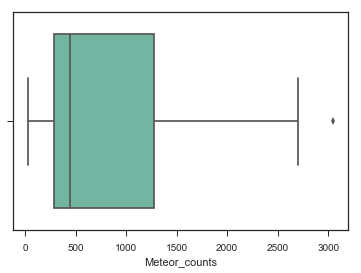

In [32]:
# We look at the distribution of meteor landings per year. Very rightly skewed with perhaps one outlier. Not troubling.
sns.boxplot(yearly_counts['Meteor_counts'])

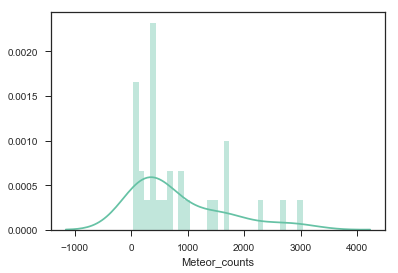

In [33]:
# Here's another way to look at the distribution. Same story.
sns.distplot(yearly_counts['Meteor_counts'], bins=30)

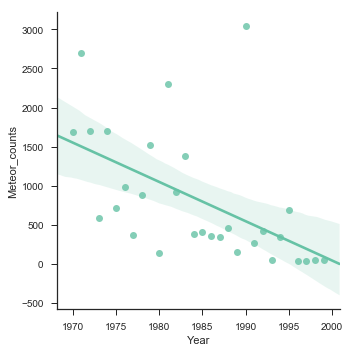

In [34]:
# Now we can plot meteor landings by year. They're decreasing! That is very comforting.
sns.lmplot(x='Year', y='Meteor_counts', data=yearly_counts)

### Dataset 3: Average Weather in  Houston, TX

Here we look at a dataset of weather variables measured in Houston, TX. This dataset has the recorded temperature and precipitation from 1 July 2014 to 30 June 2015. It was downloaded from FiveThirtyEight. It is very clean and doesn't need to be changed very much for what we want to do. First we look at summary statistics and correlations, which are about as interesting as we would expect them to be. Then we look at how average max temp and average max temp are related by using a few different regression models with scatter plots.

In [35]:
# We import the dataset and look at the formats. Ints and floats will be easy to work with.
houston_df = pd.read_csv("C:\\Users\\jacob\Documents\\Datasets\\KHOUweather.csv", header=0, index_col='date')
houston_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2014-7-1 to 2015-6-30
Data columns (total 12 columns):
actual_mean_temp         365 non-null int64
actual_min_temp          365 non-null int64
actual_max_temp          365 non-null int64
average_min_temp         365 non-null int64
average_max_temp         365 non-null int64
record_min_temp          365 non-null int64
record_max_temp          365 non-null int64
record_min_temp_year     365 non-null int64
record_max_temp_year     365 non-null int64
actual_precipitation     365 non-null float64
average_precipitation    365 non-null float64
record_precipitation     365 non-null float64
dtypes: float64(3), int64(9)
memory usage: 37.1+ KB


In [36]:
# We show that the dataset isn't missing any observations.
houston_df.columns[houston_df.isnull().any()]

Index([], dtype='object')

In [37]:
# We delete a few columns we won't be using.
cols_delete = ['actual_mean_temp', 'actual_min_temp', 'actual_max_temp', 'actual_precipitation']
houston_df = houston_df.drop(labels=cols_delete, axis=1)

In [38]:
# The most interesting part of this to me is that the record_min_temp_year is the average record min temp year is 1955 and the 
# average max temp year is 1969. That is pretty much what we're going to show later in our poor man's global warming test.
houston_df.describe()

,average_min_temp,average_max_temp,record_min_temp,record_max_temp,record_min_temp_year,record_max_temp_year,average_precipitation,record_precipitation
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,60.084932,79.808219,40.446575,92.523288,1955.219178,1969.545205,0.136356,3.016493
std,11.694646,11.315235,17.372155,8.149876,38.149520,35.903966,0.031842,1.491180
min,43.000000,62.000000,5.000000,78.000000,1889.000000,1890.000000,0.090000,0.750000
25%,49.000000,69.000000,25.000000,85.000000,1912.000000,1947.000000,0.110000,2.000000
50%,60.000000,81.000000,40.000000,92.000000,1973.000000,1980.000000,0.130000,2.700000
75%,72.000000,91.000000,57.000000,100.000000,1985.000000,1999.000000,0.160000,3.570000
max,75.000000,95.000000,69.000000,109.000000,2014.000000,2013.000000,0.220000,10.340000


In [39]:
# The interesting thing here is that the record years are negatively correlated with many of the other variables. I don't really
# know why that is the case. It's hard for me to think about how they arer related.
houston_df.corr()

,average_min_temp,average_max_temp,record_min_temp,record_max_temp,record_min_temp_year,record_max_temp_year,average_precipitation,record_precipitation
average_min_temp,1.000000,0.997149,0.978154,0.964430,-0.010609,0.020199,0.411030,0.213400
average_max_temp,0.997149,1.000000,0.974365,0.965007,-0.004427,0.016460,0.398292,0.215895
record_min_temp,0.978154,0.974365,1.000000,0.946954,0.012988,0.035224,0.351002,0.200197
record_max_temp,0.964430,0.965007,0.946954,1.000000,-0.014366,0.020306,0.358629,0.192600
record_min_temp_year,-0.010609,-0.004427,0.012988,-0.014366,1.000000,-0.112259,-0.027158,-0.046671
record_max_temp_year,0.020199,0.016460,0.035224,0.020306,-0.112259,1.000000,0.022096,0.022817
average_precipitation,0.411030,0.398292,0.351002,0.358629,-0.027158,0.022096,1.000000,0.285359
record_precipitation,0.213400,0.215895,0.200197,0.192600,-0.046671,0.022817,0.285359,1.000000


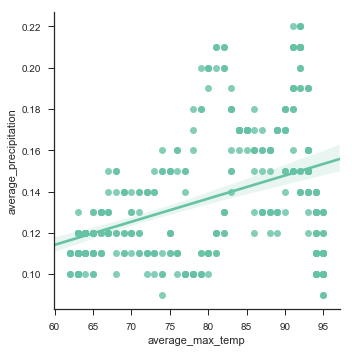

In [40]:
# Here we plot average max temp against average precipitation with a simple linear regression. The line suggests precipitation
# is correlated with higher temperatures.
sns.lmplot(x='average_max_temp', y='average_precipitation', data=houston_df, order=1)

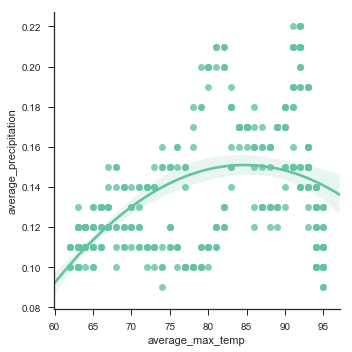

In [41]:
# Here we plot the same thing, but we allow our function to take on a quadratic form. Now there is a certain average max
# temperature associated with the highest average precipitation, somewhere around 85 degress F.
sns.lmplot(x='average_max_temp', y='average_precipitation', data=houston_df, order=2)

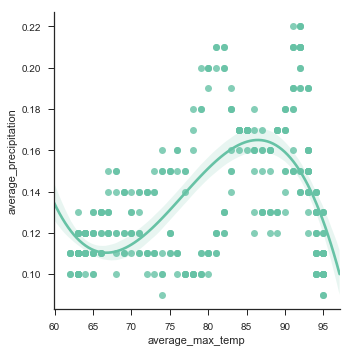

In [42]:
# Interestingly, allowing the curve to take on cubic form doesn't change the 
sns.lmplot(x='average_max_temp', y='average_precipitation', data=houston_df, order=3)

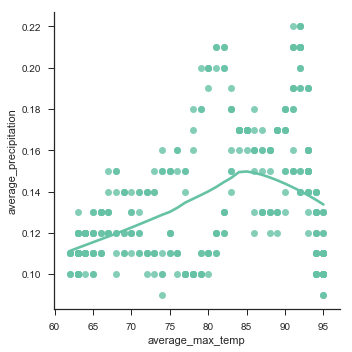

In [43]:
# Rather than increasing the orders ad nauseam, we fit the data with the nonparametric lowess model. Notice that virtually
# nothing has changed since the quadratic curve even though we're allowing many more functional forms. I think that's 
# interesting.
sns.lmplot(x='average_max_temp', y='average_precipitation', data=houston_df, lowess=True)

## THE END